In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [15]:
""" Matrices required for calculations.   """
I2 = np.matrix([[1,0],
                [0,1]])
hadamard_gate  = np.matrix([[1,1],
                            [1,-1]])* (1/np.sqrt(2))
phase_gate  = np.matrix([[1,0],
                         [0,1j]])
sigma_x  = np.matrix([[0,1],
                      [1,0]])
sigma_y  = np.matrix([[0,-1j],
                      [1j,0]])
sigma_z  = np.matrix([[1,0],
                      [0,-1]])

In [16]:
# parameters of the Hamiltonian and the Lindbladians.
b = 0.9
gamma_1 = 0.3
gamma_2 = 0.4

def lindblad_equation(density_mat,lindbladian_lst,hamiltonian = -(b/2)*sigma_x,):
    s = -1j*commutator(hamiltonian,density_mat)
    for lindbladian in lindbladian_lst:
        s += (lindbladian@density_mat@(lindbladian.conj().T)
                -1/2*anti_commutator((lindbladian.conj().T)@lindbladian,density_mat))
    return s

# known analytical solution
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss= (2*b*gamma_1)/Delta
zss = (gamma_1*(gamma_1+4*gamma_2))/Delta

theta_y_exact = 0.0#np.pi/6 # np.pi/8
theta_x_exact = np.arccos(zss/np.cos(theta_y_exact))
theta_z_exact = np.arctan(-np.sin(theta_y_exact)/np.tan(theta_x_exact))
theta_ry_exact = 2*np.arccos(-yss*np.cos(theta_z_exact)/np.sin(theta_x_exact))

print("theta_z  = ",theta_z_exact)
print("theta_x  = ",theta_x_exact)
print("theta_y  = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z  =  -0.0
theta_x  =  1.3074903825569069
theta_y  =  0.0
theta_ry =  3.658067794436669


In [17]:
def linear_function_prediction(N,K,operator_linear,list_of_shadows):
    list_of_means = []
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0
        for j in range(N*(k-1)+1,N*k+1):
            rho_j = list_of_shadows[j-1]
            shadows_mean += np.trace(operator_linear@rho_j )
            
        list_of_means.append(shadows_mean/N)
        
    # calculating the median of K means
    return np.median(list_of_means)

def quadratic_function_prediction(N,K,operator_m,operator_n,list_of_shadows):
    
    list_of_means = []
    
    SWAP = np.matrix([[1,0,0,0],
                      [0,0,1,0],
                      [0,1,0,0],
                      [0,0,0,1]])
    r"""
    
    calculating the operator O. Note that the order of operator_m and operator_n is irrelevant.
    
    """
    
    O_quadratic = SWAP@np.kron(operator_m,operator_n)
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0        
        for j in range(N*(k-1)+1,N*k+1):
            for l in range(N*(k-1)+1,N*k+1):
                if j != l:
                    rho_j = list_of_shadows[j-1]
                    rho_l = list_of_shadows[l-1]
                    shadows_mean += np.trace(O_quadratic@np.kron(rho_j,rho_l))
                    
        list_of_means.append(shadows_mean/(N*(N-1)))
        
    # calculating their median
    return np.median(list_of_means)

In [44]:
N = 50
K = 10

path ="/Users/sasankadowarah/Ultimate_QM_MM/codes-for-cluster/single_qubit_shadow_50_10_50_256"
os.chdir(path)

# list to store the cost function value at each angles
cost_function_matrix = np.zeros(50)

number_of_repetitions = 256
number_of_angle_divisions = 50

angles_lst = np.linspace(0,2*np.pi,number_of_angle_divisions)
for repetition in range(number_of_repetitions):
    os.chdir(path+"/b"+str(repetition))
    cost_function_f = np.load("cost_function_matrix.npy")
    cost_function_matrix = np.vstack((cost_function_matrix, cost_function_f))
    
"""for repetition in range(number_of_repetitions):
    
    os.chdir(path+"/b"+str(repetition))
    
    # value of cost function at each repetitions
    cost_function_one_rep = []
    
    for angle_index in range(number_of_angle_divisions):
        
        quadratic_function_i_i_lst = []
        quadratic_function_y_i_lst = []    
        quadratic_function_z_i_lst = []    
        quadratic_function_x_x_lst = []
        quadratic_function_z_z_lst = []        
        quadratic_function_y_z_lst = [] 
        
        exact_rho = np.load("exact_density_matrix_400_"+str(repetition)+"_"+str(angle_index)+".npy")
        shadows_lst = np.load("shadow_density_matrix_400_"+str(repetition)+"_"+str(angle_index)+".npy")
        
        # calculating the quadratic functions
        quadratic_function_i_i_lst.append(quadratic_function_prediction(N,K,I2,I2,shadows_lst))
        quadratic_function_y_i_lst.append(quadratic_function_prediction(N,K,sigma_y,I2,shadows_lst))
        quadratic_function_z_i_lst.append(quadratic_function_prediction(N,K,sigma_z,I2,shadows_lst))
        quadratic_function_x_x_lst.append(quadratic_function_prediction(N,K,sigma_x,sigma_x,shadows_lst))
        quadratic_function_z_z_lst.append(quadratic_function_prediction(N,K,sigma_z,sigma_z,shadows_lst))    
        quadratic_function_y_z_lst.append(quadratic_function_prediction(N,K,sigma_y,sigma_z,shadows_lst))
        
        quadratic_function_i_i_lst = np.array(quadratic_function_i_i_lst)
        quadratic_function_y_i_lst = np.array(quadratic_function_y_i_lst)    
        quadratic_function_z_i_lst = np.array(quadratic_function_z_i_lst)
        quadratic_function_x_x_lst = np.array(quadratic_function_x_x_lst)
        quadratic_function_z_z_lst = np.array(quadratic_function_z_z_lst)
        quadratic_function_y_z_lst = np.array(quadratic_function_y_z_lst) 
        
        # calculating the quadratic function with the exact density matrix
        quadratic_function_i_i_lst_exact.append(np.trace(exact_rho@exact_rho))
        quadratic_function_y_i_lst_exact.append(np.trace(sigma_y@exact_rho@exact_rho))
        quadratic_function_z_i_lst_exact.append(np.trace(sigma_z@exact_rho@exact_rho))
        quadratic_function_x_x_lst_exact.append(np.trace(sigma_x@exact_rho@sigma_x@exact_rho))
        quadratic_function_z_z_lst_exact.append(np.trace(sigma_z@exact_rho@sigma_z@exact_rho))
        quadratic_function_y_z_lst_exact.append(np.trace(sigma_y@exact_rho@sigma_z@exact_rho))
        
        # calculating the cost function at each angle
        cost_function_one_rep.append(((b**2/2)*(-quadratic_function_x_x_lst+quadratic_function_i_i_lst)
        + (1j*b*gamma_1/4)*(4*1j*quadratic_function_y_i_lst-2*1j*quadratic_function_y_z_lst)
        -2*gamma_2*b*(quadratic_function_y_z_lst)
        +(gamma_1**2/16)*(10*quadratic_function_i_i_lst+6*quadratic_function_z_z_lst-16*quadratic_function_z_i_lst)
        +(gamma_1*gamma_2/2)*(-2*quadratic_function_z_z_lst+2*quadratic_function_i_i_lst)
        +(2*gamma_2**2)*(quadratic_function_i_i_lst-quadratic_function_z_z_lst))[0])
    #print()
    cost_function_matrix = np.vstack((cost_function_matrix, np.array(cost_function_one_rep)))""";

In [45]:
#path ="/Users/sasankadowarah/Ultimate_QM_MM/codes-for-cluster"
#os.chdir(path)
#np.save("cost_function_matrix_25_25_50_256.npy",cost_function_matrix)

In [46]:
# density matrix in terms of angles
def rho_SS_from_angles(theta_x,theta_y,theta_z,theta_ry):
    rho_11 = (1/2)*(1+np.cos(theta_x)*np.cos(theta_y))
    rho_12 = ((1/2)*np.exp(-1j*theta_z)*np.cos(theta_ry/2)*(np.sin(theta_y)*np.cos(theta_x)
                                                           +1j*np.sin(theta_x)))
    return np.matrix([[rho_11,rho_12],[rho_12.conj(),1-rho_11]])

def cost_function_from_exact_density_matrix(density_matrix):
    return ((b**2/2)*np.trace(-sigma_x@density_matrix@sigma_x@density_matrix+density_matrix**2)
        + (1j*b*gamma_1/4)*np.trace(4*1j*sigma_y@density_matrix**2-2*1j*sigma_z@density_matrix@sigma_y@density_matrix)
        -2*gamma_2*b*np.trace(sigma_y@density_matrix@sigma_z@density_matrix)
        +(gamma_1**2/16)*np.trace(10*density_matrix**2+6*sigma_z@density_matrix@sigma_z@density_matrix-16*sigma_z@density_matrix**2)
        +(gamma_1*gamma_2/2)*np.trace(-2*density_matrix@sigma_z@density_matrix@sigma_z+2*density_matrix**2)
        +(2*gamma_2**2)*np.trace(density_matrix**2-sigma_z@density_matrix@sigma_z@density_matrix))

exact_rho_SS_at_angles = [rho_SS_from_angles(theta_x_angle,theta_y_exact, theta_z_exact, theta_ry_exact) 
                          for theta_x_angle in angles_lst]
cost_function_exact = np.array([cost_function_from_exact_density_matrix(exact_rho_SS_angles)
                      for exact_rho_SS_angles in exact_rho_SS_at_angles])

In [47]:
cost_function_mean = np.sum(cost_function_matrix, axis = 0)/number_of_repetitions 

cost_function_SEOM = []
for j in range(number_of_angle_divisions):
    cost_function_SEOM.append((np.std(cost_function_matrix[:,j], axis = 0,ddof=1)/np.sqrt(number_of_repetitions-1)))

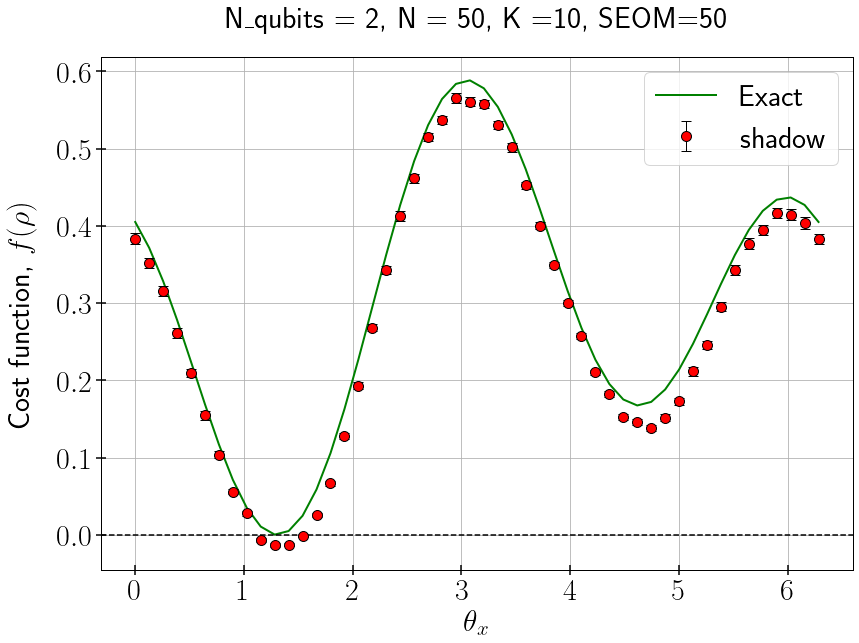

In [48]:
large = 30; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(9)

color_1 = "green"
color_2 = "red"
#angles_lst = np.linspace(-np.pi,np.pi,50)
#plt.plot(angles_lst,cost_function_mean.real,label="",c="tab:orange")
plt.plot(angles_lst,cost_function_exact.real,linewidth=2,c=color_1,label="Exact")
plt.errorbar(angles_lst,cost_function_mean.real,yerr = np.array(cost_function_SEOM).real,
            c="k",label="shadow",
                fmt="o",mfc=color_2,ms = 10,mew=1,capsize=5, elinewidth=1,)
ax = f.gca()
ax.axhline(0, color="k",linestyle="--",alpha=1)
#ax.axvline(theta_x_exact, color="green",label = r"Exact $\theta_{x}$",linestyle="--")

plt.title(r"N_qubits = 2, N = 50, K =10, SEOM=50")
plt.xlabel(r"$\theta_{x}$")
plt.ylabel(r"Cost function, $f(\rho )$",labelpad=20)
#plt.ylim([-1,1])
plt.legend()
plt.grid(True) 
f.tight_layout(pad=1.0)
#plt.gcf().subplots_adjust(bottom=0.2)
#plt.gcf().subplots_adjust(left=0.2)
# Set the linewidth of the spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)  # Change the value to adjust thickness 
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1.5, color="k")
path ="/Users/sasankadowarah/Ultimate_QM_MM/codes-for-cluster/"
os.chdir(path)
#plt.savefig("cost_function_single_qubit_50_10_50_256.jpg",dpi=300)
plt.show()

## two dimensional potential plot

In [49]:
exact_rho_SS_at_angles = []
for angle_z in angles_lst:
    for angle_x in angles_lst:
        exact_rho_SS_at_angles.append(rho_SS_from_angles(angle_x,theta_y_exact, angle_z, theta_ry_exact))
        
#cost_function_exact = np.array([cost_function_from_exact_density_matrix(exact_rho_SS_angles)
#                      for exact_rho_SS_angles in exact_rho_SS_at_angles])

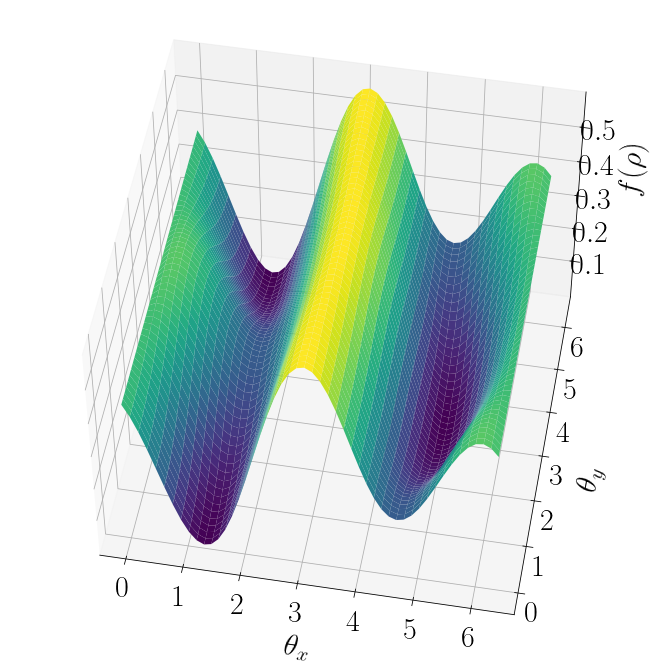

In [317]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

# Example using scatter plot:
X, Y = np.meshgrid(np.array([angles_lst]), np.array([angles_lst]))
Z = cost_function_exact.reshape((50,50)).real

# Create a 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50, azim=280) 
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel(r"$\theta_{x}$",labelpad=20)
ax.set_ylabel(r"$\theta_{y}$",labelpad=20)
ax.set_zlabel(r"$f(\rho)$",labelpad=20)
plt.show()

In [163]:
N = 40
K = 10

path ="/Users/sasankadowarah/Ultimate_QM_MM/codes-for-cluster/single_qubit_2d_40_10_50_64"
os.chdir(path)

# list to store the cost function value at each angles
cost_function_matrix_2d = np.zeros(50*50)

number_of_repetitions = 64
number_of_angle_divisions = 50

angles_lst = np.linspace(0,2*np.pi,number_of_angle_divisions)
for repetition in range(number_of_repetitions):
    os.chdir(path+"/b"+str(repetition))
    cost_function_f = np.load("cost_function_matrix.npy")
    cost_function_matrix_2d = np.vstack((cost_function_matrix_2d, cost_function_f))

In [165]:
cost_function_mean_2d = np.sum(cost_function_matrix_2d, axis = 0)/number_of_repetitions 

cost_function_SEOM_2d = []
for j in range(number_of_angle_divisions):
    cost_function_SEOM_2d.append((np.std(cost_function_matrix_2d[:,j], axis = 0,ddof=1)/np.sqrt(number_of_repetitions-1)))

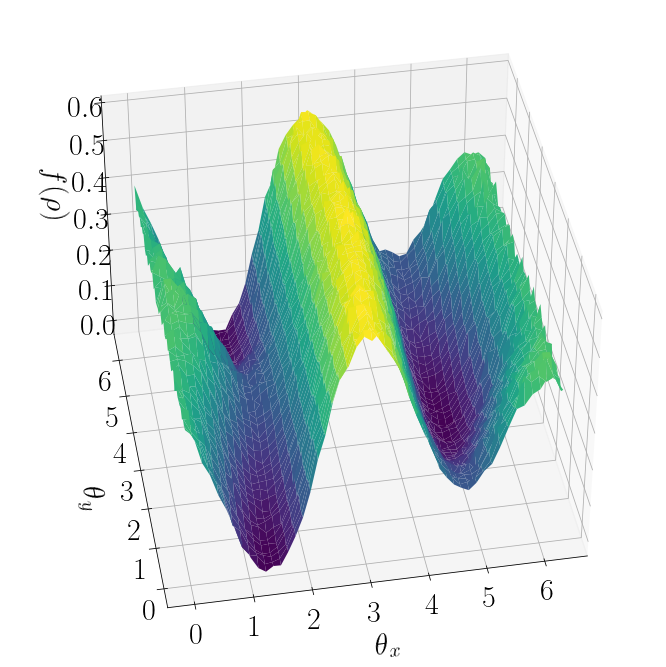

In [342]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

# Example using scatter plot:
X, Y = np.meshgrid(np.array([angles_lst]), np.array([angles_lst]))
Z = cost_function_mean_2d.reshape((50,50)).real

# Create a 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=40, azim=90+170) 
ax.plot_surface(X, Y, Z, cmap="viridis")
ax.set_xlabel(r"$\theta_{x}$",labelpad=20)
ax.set_ylabel(r"$\theta_{y}$",labelpad=20)
ax.set_zlabel(r"$f(\rho)$",labelpad=20)
plt.show()

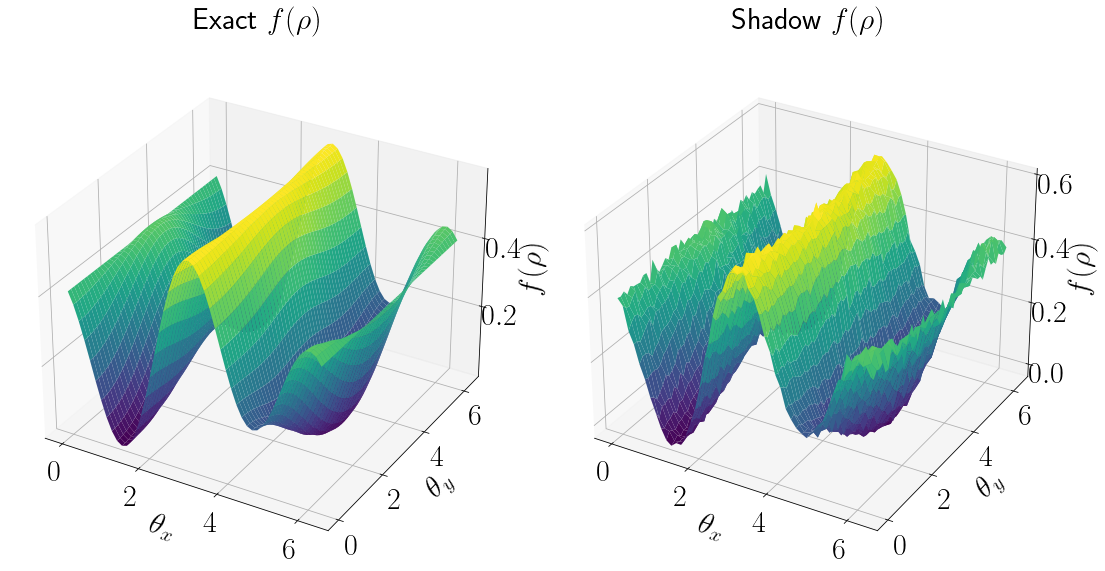

In [221]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(16, 8))

Z1 = cost_function_exact.reshape((50,50)).real

# Create the first 3D plot
axs[0].plot_surface(X, Y, Z1, cmap="viridis")
axs[0].set_xlabel(r"$\theta_{x}$", labelpad=10)
axs[0].set_ylabel(r"$\theta_{y}$", labelpad=10)
axs[0].set_zlabel(r"$f(\rho)$", labelpad=10)
axs[0].set_title(r"Exact $f(\rho)$")

Z2 = cost_function_mean_2d.reshape((50,50)).real
# Create the second 3D plot
axs[1].plot_surface(X, Y, Z2, cmap="viridis")
axs[1].set_xlabel(r"$\theta_{x}$", labelpad=10)
axs[1].set_ylabel(r"$\theta_{y}$", labelpad=10)
axs[1].set_zlabel(r"$f(\rho)$", labelpad=10)
axs[1].set_title(r"Shadow $f(\rho)$")
elevation = 20
azimuthal = 80
plt.tight_layout()
fig.tight_layout(pad=1.0)
path ="/Users/sasankadowarah/Ultimate_QM_MM/codes-for-cluster/"
os.chdir(path)
#plt.savefig("3d_cost_function_single_qubit_40_10_50_64.jpg",dpi=300)
plt.show()

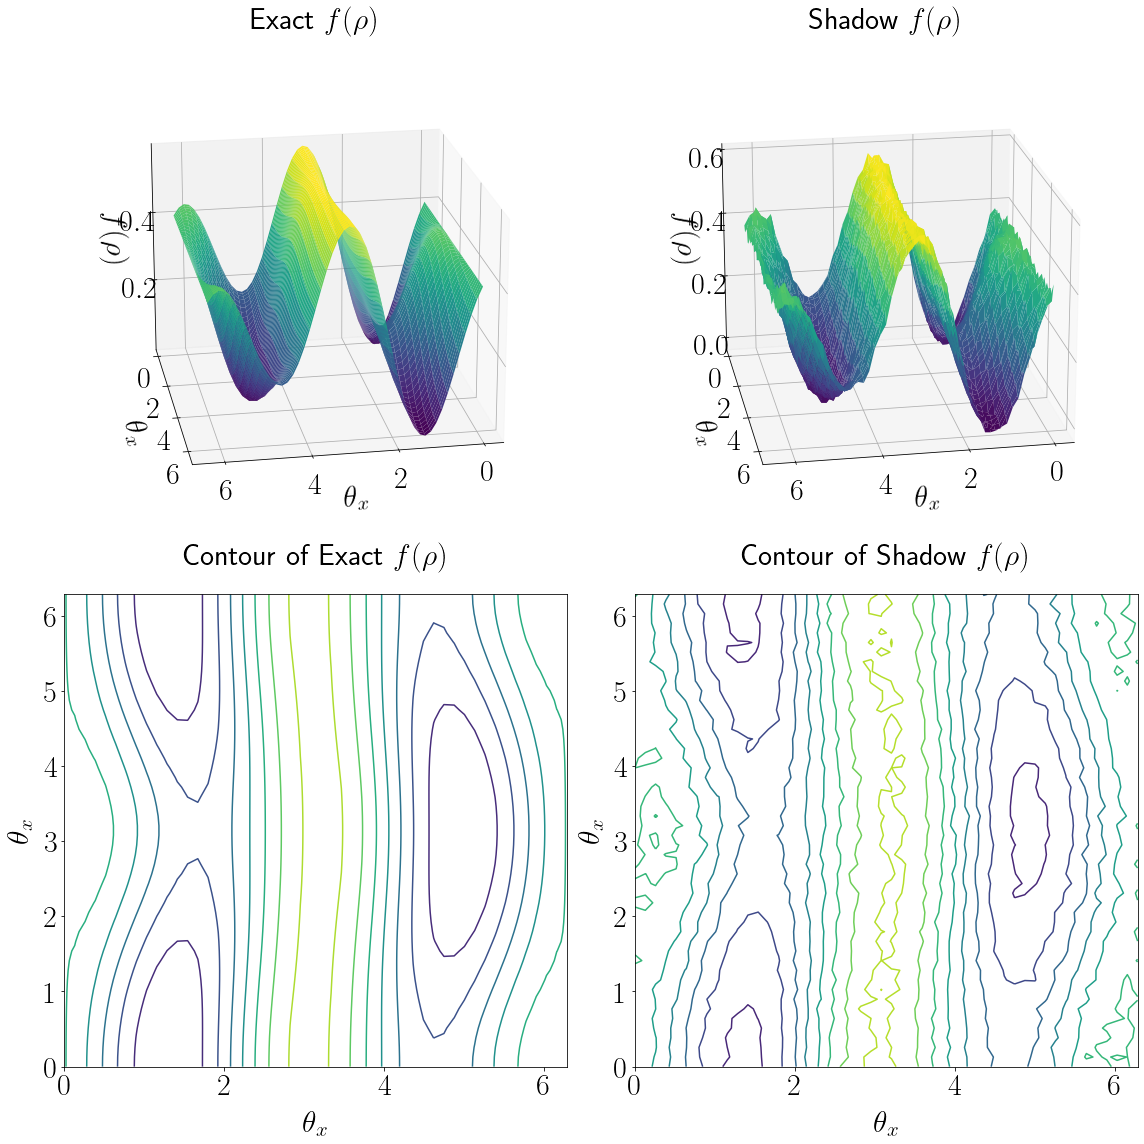

In [209]:
# Create a figure with four subplots
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(2, 2, 1, projection= "3d")
ax2 = fig.add_subplot(2, 2, 2, projection= "3d")
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

Z1 = cost_function_exact.reshape((50,50)).real
Z2 = cost_function_mean_2d.reshape((50,50)).real

# Create the first 3D plot
ax1.plot_surface(X, Y, Z1, cmap="viridis")
ax1.set_xlabel(r"$\theta_{x}$", labelpad=10)
ax1.set_ylabel(r"$\theta_{x}$", labelpad=10)
ax1.set_zlabel(r"$f(\rho)$", labelpad=10)
ax1.set_title(r"Exact $f(\rho)$")

# Create the second 3D plot
ax2.plot_surface(X, Y, Z2, cmap="viridis")
ax2.set_xlabel(r"$\theta_{x}$", labelpad=10)
ax2.set_ylabel(r"$\theta_{x}$", labelpad=10)
ax2.set_zlabel(r"$f(\rho)$", labelpad=10)
ax2.set_title(r"Shadow $f(\rho)$")

# Create the first contour plot
ax3.contour(X, Y, Z1, cmap="viridis")
ax3.set_xlabel(r"$\theta_{x}$", labelpad=10)
ax3.set_ylabel(r"$\theta_{x}$", labelpad=10)
ax3.set_title(r"Contour of Exact $f(\rho)$")

# Create the second contour plot
ax4.contour(X, Y, Z2, cmap="viridis")
ax4.set_xlabel(r"$\theta_{x}$", labelpad=10)
ax4.set_ylabel(r"$\theta_{x}$", labelpad=10)
ax4.set_title(r"Contour of Shadow $f(\rho)$")
elevation = 20
azimuthal = 80
ax1.view_init(elev=elevation, azim=azimuthal)
ax2.view_init(elev=elevation, azim=azimuthal)

plt.tight_layout()
plt.show()